## Import

In [ ]:
# model architecture adapted from https://github.com/ydataai/ydata-synthetic - a model for generating credit card data
# modello GAN
# import os
import numpy as np

# Check that imports for the rest of the file work.
import tensorflow as tf
import tensorflow.compat.v1 as tfv1
!pip install tensorflow-gan
import tensorflow_gan as tfgan
import matplotlib.pyplot as plt
# Allow matplotlib images to render immediately.
%matplotlib inline
tfv1.logging.set_verbosity(tfv1.logging.ERROR)  # Disable noisy outputs.


from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Model, layers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 6.3 MB/s eta 0:00:00


In [ ]:
!pip install sdv
from sdv.evaluation.single_table import get_column_plot
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import run_diagnostic

import pandas as pd
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.1/137.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.7/170.7 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.9 MB/s eta 0:00:00


In [ ]:
# link & mount to google drive to import data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pre-processing per la WGAN: normalizzazione e splitting

In [ ]:
dataFin = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/dataCleanedEncoded.csv')

In [ ]:
data35 = dataFin[['FlowDuration', 'BwdPacketLengthStd', 'PacketLengthVariance', 'DstPort',
       'TotalLengthofFwdPacket', 'PacketLengthStd', 'FlowIATMax',
       'FlowPackets/s', 'FwdPacketLengthMax', 'BwdPacketLengthMax',
       'BwdSegmentSizeAvg', 'RSTFlagCount', 'BwdPacketLengthMean',
       'SubflowFwdBytes', 'PacketLengthMean', 'PacketLengthMax',
       'FwdPackets/s', 'AveragePacketSize', 'FwdSegmentSizeAvg',
       'FwdPacketLengthMean', 'FlowBytes/s', 'SubflowBwdBytes',
       'BwdBulkRateAvg', 'FwdPacketLengthStd', 'TotalLengthofBwdPacket',
       'FwdHeaderLength', 'FlowIATMean', 'BwdHeaderLength', 'FwdRSTFlags',
       'FWDInitWinBytes', 'BwdInitWinBytes', 'FwdIATMax', 'BwdPackets/s',
       'ACKFlagCount', 'FwdSegSizeMin','L_BENIGN','L_Infiltration_Portscan','L_DDoS','L_DoS','L_BruteForce','L_Botnet']]

In [ ]:
data35.shape

(2099769, 41)

In [ ]:
data35.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/dataCleanedEncoded35.csv', index = False)

**PARTI DA QUA**

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/dataCleanedEncoded35.csv')

In [ ]:
#d_Benign = dataFin[dataFin['L_BENIGN'] == 1]
#d_Portscan = data[data['L_Infiltration_Portscan'] == 1]
d_DDoS = data[data['L_DDoS'] == 1]
#d_DoS = data[data['L_DoS'] == 1]
#d_BruteForce = dataFin[dataFin['L_BruteForce'] == 1]
#d_Botnet = dataFin[dataFin['L_Botnet'] == 1]

In [ ]:
d_DDoS.head()

,FlowDuration,BwdPacketLengthStd,PacketLengthVariance,DstPort,TotalLengthofFwdPacket,PacketLengthStd,FlowIATMax,FlowPackets/s,FwdPacketLengthMax,BwdPacketLengthMax,...,FwdIATMax,BwdPackets/s,ACKFlagCount,FwdSegSizeMin,L_BENIGN,L_Infiltration_Portscan,L_DDoS,L_DoS,L_BruteForce,L_Botnet
45,2137952,2208.914892,3.196734e+06,80,20,1787.941247,1492974,5.612848,20,4380,...,1492974,2.338687,11,20,0,0,1,0,0,0
80,5236060,3348.440682,5.113322e+06,80,20,2261.265671,4685849,2.482783,20,7300,...,4685849,0.954916,12,20,0,0,1,0,0,0
100,11999421,3640.785286,5.739460e+06,80,20,2395.717103,11938684,1.166723,20,8760,...,11938684,0.416687,13,20,0,0,1,0,0,0
106,5789781,3329.858105,5.454425e+06,80,20,2335.471004,5675830,2.072617,20,7215,...,5675830,0.863591,11,20,0,0,1,0,0,0
232,2076972,2202.130219,2.847563e+06,80,20,1687.472466,2040984,6.740582,20,5840,...,2040984,2.888821,13,20,0,0,1,0,0,0


## Carico dati

In [ ]:
# import pre-processed data from google drive and store in dataframe using pandas function
# split the dataset into 6 different datasets, one for each class
# GAN model will generate samples for one class at a time, therefore dataframe needs to be split by class. Will be joined again after all samples have been generated.

**Drop label category from each dataframe**

In [ ]:
#colonna superflua perché tanto ho già diviso per classi... la label di ogni df è uguale obv
##dfBenign = d_Benign.drop(['L_BENIGN','L_Infiltration_Portscan','L_DDoS','L_DoS','L_BruteForce','L_Botnet'], axis=1)
#dfPortscan = d_Portscan.drop(['L_BENIGN','L_Infiltration_Portscan','L_DDoS','L_DoS','L_BruteForce','L_Botnet'], axis=1)
dfDDoS = d_DDoS.drop(['L_BENIGN','L_Infiltration_Portscan','L_DDoS','L_DoS','L_BruteForce','L_Botnet'], axis=1)
#dfDoS = d_DoS.drop(['L_BENIGN','L_Infiltration_Portscan','L_DDoS','L_DoS','L_BruteForce','L_Botnet'], axis=1)
#dfBruteForce = d_BruteForce.drop(['L_BENIGN','L_Infiltration_Portscan','L_DDoS','L_DoS','L_BruteForce','L_Botnet'], axis=1)
#dfBotnet = d_Botnet.drop(['L_BENIGN','L_Infiltration_Portscan','L_DDoS','L_DoS','L_BruteForce','L_Botnet'], axis=1)

In [ ]:
pd.options.display.float_format = '{:,.20f}'.format

In [ ]:
dfDDoS.head()

,FlowDuration,BwdPacketLengthStd,PacketLengthVariance,DstPort,TotalLengthofFwdPacket,PacketLengthStd,FlowIATMax,FlowPackets/s,FwdPacketLengthMax,BwdPacketLengthMax,...,FwdHeaderLength,FlowIATMean,BwdHeaderLength,FwdRSTFlags,FWDInitWinBytes,BwdInitWinBytes,FwdIATMax,BwdPackets/s,ACKFlagCount,FwdSegSizeMin
45,2137952,"2,208.91489197750661332975","3,196,733.90151515137404203415",80,20,"1,787.94124666196807993401",1492974,5.61284818368232851782,20,4380,...,152,"194,359.27272727270610630512",112,1,8192,229,1492974,2.33868674320097014174,11,20
80,5236060,"3,348.44068186969707312528","5,113,322.43589743599295616150",80,20,"2,261.26567123313407137175",4685849,2.48278285581143087768,20,7300,...,172,"436,338.33333333337213844061",112,1,8192,229,4685849,0.95491648300439635477,12,20
100,11999421,"3,640.78528617110305276583","5,739,460.43956043943762779236",80,20,"2,395.71710340775416625547",11938684,1.16672296104953709950,20,8760,...,204,"923,032.38461538462433964014",112,1,8192,229,11938684,0.41668677180340618627,13,20
106,5789781,"3,329.85810508495978865540","5,454,424.81060606148093938828",80,20,"2,335.47100401740408415208",5675830,2.07261725443501232391,20,7215,...,152,"526,343.72727272729389369488",112,1,8192,229,5675830,0.86359052268125513496,11,20
232,2076972,"2,202.13021867463612579741","2,847,563.32417582441121339798",80,20,"1,687.47246619784118593088",2040984,6.74058196258784381172,20,5840,...,172,"159,767.07692307693650946021",132,1,8192,229,2040984,2.88882084110907610963,13,20


In [ ]:
dataTrain = dfDDoS.copy()

In [ ]:
dataTrain.shape

(95133, 35)

```
BENIGN                   1594422
Infiltration_Portscan     230853
DoS                       171620
DDoS                       95133
BruteForce                  7005
Botnet                       736
```


**Normalizzazione**

In [ ]:
np.set_printoptions(suppress=True)

In [ ]:
dataNorm = dataTrain.values

from sklearn.preprocessing import MinMaxScaler

# Apply min-max normalization using MinMaxScaler
# data è un NP ARRAY adatto per le reti neurali (standard behaviour)
scaler = MinMaxScaler()
dataNorm = scaler.fit_transform(dataNorm)

In [ ]:
dataNorm

array([[0.02558527, 0.32996575, 0.19030948, ..., 0.02062482, 0.31578947,
        1.        ],
       [0.06335038, 0.5001871 , 0.30441112, ..., 0.00816166, 0.36842105,
        1.        ],
       [0.14579395, 0.54385727, 0.34168744, ..., 0.00331401, 0.42105263,
        1.        ],
       ...,
       [0.04574787, 0.30069265, 0.15753802, ..., 0.01381204, 0.47368421,
        1.        ],
       [0.07294093, 0.45167128, 0.2826019 , ..., 0.00703815, 0.31578947,
        1.        ],
       [0.02424665, 0.52904688, 0.35110589, ..., 0.01732447, 0.26315789,
        1.        ]])

In [ ]:
dataNorm.shape

(95133, 35)

In [ ]:
#Min-max normalization is effective in scaling features to a specific range (commonly between 0 and 1),
#and it helps to handle differences in magnitudes between features. If your dataset is already in a suitable range
#and you haven't observed issues related to skewed distributions or outliers, adding a power transform
#might not be necessary and could even introduce unnecessary complexity.

## **Define model architecture**

In [ ]:
import matplotlib.pyplot as pyplot

#PLOTTINO
# create a line plot of loss for the gan and save to file
def plot_history(c_hist, g_hist):
 # plot loss
 pyplot.plot(c_hist, label='c-loss')
 pyplot.plot(g_hist, label='g-loss')
 pyplot.legend()
 pyplot.show()

In [ ]:
# Wasserstein loss function
def wasserstein_loss(y_true, y_pred):
    return tf.keras.backend.mean(tf.keras.backend.sum(y_true * y_pred, axis=-1))

#### Primo Codice Architettura

In [ ]:
#classe del modello intero GAN
class GAN():

    def __init__(self, gan_args):
        [self.batch_size, lr, self.noise_dim,
         self.data_dim, layers_dim] = gan_args

        self.generator = Generator(self.batch_size).\
            build_model(input_shape=(self.noise_dim,), dim=layers_dim, data_dim=self.data_dim)

        self.discriminator = Discriminator(self.batch_size).\
            build_model(input_shape=(self.data_dim,), dim=layers_dim)

        #optimizer
        optimizer = tf.keras.optimizers.legacy.Adam(lr, 0.5)


        # Build and compile the discriminator
        self.discriminator.compile(loss=wasserstein_loss,
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # The generator takes noise as input and generates samples
        z = Input(shape=(self.noise_dim,))
        record = self.generator(z)

        # For the combined model only the generator is trained
        self.discriminator.trainable = False

        # The discriminator takes generated samples as input and determines validity
        validity = self.discriminator(record)

        # The combined model
        # Trains the generator to try and create samples that will fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss=wasserstein_loss, optimizer=optimizer)

    def get_data_batch(self, train, batch_size, seed=0):
        start_i = (batch_size * seed) % len(train)
        stop_i = start_i + batch_size
        shuffle_seed = (batch_size * seed) // len(train)
        np.random.seed(shuffle_seed)
        train_ix = np.random.choice(list(train.index), replace=False, size=len(train))  # wasteful to shuffle every time
        train_ix = list(train_ix) + list(train_ix)  # duplicate to cover ranges past the end of the set
        x = train.loc[train_ix[start_i: stop_i]].values
        return np.reshape(x, (batch_size, -1))

    def train(self, data, train_arguments):
        [cache_prefix, epochs, sample_interval] = train_arguments

        data_cols = data.columns

        # Adversarial ground truths
        valid = np.ones((self.batch_size, 1))
        fake = np.zeros((self.batch_size, 1))

        d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()

        for epoch in range(epochs):
            # Discriminator
            batch_data = self.get_data_batch(data, self.batch_size)
            noise = tf.random.normal((self.batch_size, self.noise_dim))

            # Generate a batch of new samples
            gen_data = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real, d_acc1 = self.discriminator.train_on_batch(batch_data, valid)
            d_loss_fake, d_acc2 = self.discriminator.train_on_batch(gen_data, fake)

            # Generator
            noise = tf.random.normal((self.batch_size, self.noise_dim))
            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            #Therefore, using the loss values directly is not recommended in GANs.
            #Instead, metrics such as the Inception Score, Frechet Inception Distance (FID score),
            #and perceptual similarity measures (LPIPS) are used for interpreting the results.
            #PERFORMANCE
            d1_hist.append(d_loss_real)
            d2_hist.append(d_loss_fake)
            g_hist.append(g_loss)
            a1_hist.append(d_acc1)
            a2_hist.append(d_acc2)
            # Plot the progress
            #print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
            print('==>> %d, dRLoss=%.3f, dFLoss=%.3f gLoss=%.3f, accR=%d, accF=%d' % (epoch, d_loss_real, d_loss_fake, g_loss, int(100*d_acc1), int(100*d_acc2)))
        plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)



#Singola classe del G
class Generator():
    def __init__(self, batch_size):
        self.batch_size = batch_size

    def build_model(self, input_shape, dim, data_dim):
        input_layer = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim, activation='relu')(input_layer)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dense(dim * 4, activation='relu')(x)
        # Use sigmoid activation in the output layer to constrain values to [0, 1]
        output_layer = Dense(data_dim, activation='sigmoid')(x)
        return Model(inputs=input_layer, outputs=output_layer)


#Singola classe del D
class Discriminator():
    def __init__(self,batch_size):
        self.batch_size=batch_size

    def build_model(self, input_shape, dim):
        input = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim * 4, activation='relu')(input)
        x = Dropout(0.2)(x)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dropout(0.2)(x)
        x = Dense(dim, activation='relu')(x)
        x = Dense(1, activation='linear')(x) #linear for WGAN ?
        return Model(inputs=input, outputs=x)

## Secondo Codice Architettura - metodo standard con nparray input

In [ ]:
# Generator
def build_generator(z_dim, output_dim):
    model = tf.keras.Sequential([
        layers.Dense(128, input_dim=z_dim, activation='relu'),
        #layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        #layers.BatchNormalization(),
        layers.Dense(output_dim, activation='sigmoid')  #activation scelta perché i dati sono normalizzati [0,1]
    ])
    return model

# Critic
def build_critic(input_dim):
    model = tf.keras.Sequential([
        layers.Dense(256, input_dim=input_dim, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1)  # No activation for WGAN critic
    ])
    return model


In [ ]:
# Hyperparameters
z_dim = 10    #SPERIMENTA
output_dim = 35 # Number of features in your data
critic_input_dim = 35 # Number of features in your data
lr_generator = 0.000001
lr_critic = 0.000001

# Training hyperparams
num_epochs = 100
batch_size = 64

In [ ]:
# Build and compile the generator and critic
generator = build_generator(z_dim, output_dim)
critic = build_critic(critic_input_dim)

generator_optimizer = tf.keras.optimizers.Adam(lr_generator)
critic_optimizer = tf.keras.optimizers.Adam(lr_critic)

# WGAN requires custom training loop
@tf.function
def train_step(real_data, z):
    batch_size_real = tf.shape(real_data)[0]
    batch_size_gen = tf.shape(z)[0]
    batch_size = tf.minimum(batch_size_real, batch_size_gen)

    # Train Critic
    with tf.GradientTape() as critic_tape:
        fake_data = generator(z[:batch_size])
        critic_real = critic(real_data[:batch_size])
        critic_fake = critic(fake_data)
        critic_loss = wasserstein_loss(critic_real, critic_fake)

    critic_gradients = critic_tape.gradient(critic_loss, critic.trainable_variables)
    critic_optimizer.apply_gradients(zip(critic_gradients, critic.trainable_variables))

    # Clip critic weights (important for WGAN)
    for w in critic.trainable_variables:
        w.assign(tf.clip_by_value(w, -0.01, 0.01))

    # Train Generator
    with tf.GradientTape() as gen_tape:
        fake_data = generator(z[:batch_size])
        generator_loss = -tf.reduce_mean(critic(fake_data))

    generator_gradients = gen_tape.gradient(generator_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

    return generator_loss, critic_loss


c_hist, g_hist = list(), list()
# Training loop
# Assuming 'data' is your normalized numpy array
data = dataNorm
dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(buffer_size=1000).batch(batch_size)

for epoch in range(num_epochs):
    for real_data in dataset:
        # Generate random noise as input to the generator
        z = tf.random.normal((batch_size, z_dim))
        # Train the WGAN using the train_step function
        generator_loss, critic_loss = train_step(real_data, z)
        c_hist.append(critic_loss)
        g_hist.append(generator_loss)
    # Print losses or other metrics after each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Generator Loss: {generator_loss.numpy()}, Critic Loss: {critic_loss.numpy()}")

Epoch 1/100, Generator Loss: 3.265485793235712e-05, Critic Loss: -1.2567941132246574e-10
Epoch 2/100, Generator Loss: -7.964933502080385e-06, Critic Loss: 1.600686597158507e-11
Epoch 3/100, Generator Loss: -6.934050179552287e-05, Critic Loss: -4.809406206618405e-09
Epoch 4/100, Generator Loss: -0.00021606663358397782, Critic Loss: -4.7238465583632205e-08
Epoch 5/100, Generator Loss: -0.00046950700925663114, Critic Loss: -2.1021470786308782e-07
Epoch 6/100, Generator Loss: -0.0009263038518838584, Critic Loss: -8.685315719958453e-07
Epoch 7/100, Generator Loss: -0.0022330298088490963, Critic Loss: -5.023133326176321e-06
Epoch 8/100, Generator Loss: -0.0051675718277692795, Critic Loss: -2.6614003218128346e-05
Epoch 9/100, Generator Loss: -0.009465641342103481, Critic Loss: -8.878082007868215e-05
Epoch 10/100, Generator Loss: -0.014401865191757679, Critic Loss: -0.00020312970445957035
Epoch 11/100, Generator Loss: -0.020538613200187683, Critic Loss: -0.00043162639485672116
Epoch 12/100, Ge

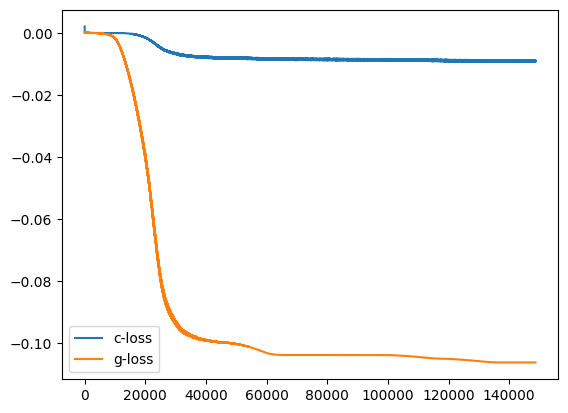

In [ ]:
plot_history(c_hist, g_hist)



```
####### CRITIC
It's common to see critic losses with magnitudes in the order of 0 to -0.1.
A more negative critic loss generally indicates that the generator
is producing samples that are closer to the real data distribution

###### GENERATOR
The generator loss is the negative of the critic loss.
A more negative generator loss indicates that the generator is improving in producing samples.

##### CONVERGENZA
If the critic loss stabilizes, it indicates that the generator
is producing samples that are consistent with the real data distribution.
If the Wasserstein distance is not stabilizing, you might need
to adjust hyperparameters, model architecture, or other training parameters.
```



# **Training** - OLD

```
BENIGN                   1594422
Infiltration_Portscan     230853
DoS                       171620
DDoS                       95133
BruteForce                  7005
Botnet                       736
```


In [ ]:
#Define model params and training params
# set up dataframe for input into model

# set generator parametes
batch_size = 128 #@param
learning_rate=0.000001 #@param  #5e-4
input_noise = 50 #@param

input_shape=35 #@param #numeroFeatures
dim=64 #@param

# set training parameters
epochs = 40 #@param
log_step = 100 #@param

In [ ]:
# assign to variable
generator_parameters = [batch_size, learning_rate, input_noise, input_shape, dim]
training_parameters = ['', epochs, log_step]

In [ ]:
# training
synthesizer = GAN(generator_parameters)

synthesizer.train(data, training_parameters)

AttributeError: ignored

In [ ]:
models = {'WGAN': ['WGAN', False, synthesizer.generator]}

In [ ]:
np.random.seed(3) # used for retestability

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#noise = np.random.normal(0,1, (1170495, 32)) # number of benign samples to be generated
#noise = np.random.normal(0,1, (70302, 32)) # number of dos hulk samples to be generated
#noise = np.random.normal(0,1, (2922, 32)) # number of ssh patator samples to be generated
#noise = np.random.normal(0,1, (2332, 32)) # number of dos slow loris samples to be generated
#noise = np.random.normal(0,1, (11, 32)) # number of heartbleed samples to be generated
noise = np.random.normal(0,1, (10000, input_noise)) # number of ddos samples to be generated

[model_name, with_class, generator_model] = models['WGAN']

X = generator_model.predict(noise)

313/313 [==============================] - 1s 2ms/step


In [ ]:
# Create a dataframe with generated samples, so can be used for evaluation later

gen_ddos_samples = pd.DataFrame(X, columns=data_columns)
# gen_dosHulk_samples = pd.DataFrame(X, columns=data_columns)
# gen_sshPatator_samples = pd.DataFrame(X, columns=data_columns)
# gen_dosSlowloris_samples = pd.DataFrame(X, columns=data_columns)
# gen_heartbleed_samples = pd.DataFrame(X, columns=data_columns)
# gen_infiltration_samples = pd.DataFrame(X, columns=data_columns)

In [ ]:
#gen_benign_samples.to_csv(r'drive/My Drive/Colab/ProjectData/gen_benign_samples.csv')
# gen_dosHulk_samples.to_csv(r'drive/My Drive/Colab/ProjectData/gen_dosHulk_samples.csv')
# gen_sshPatator_samples.to_csv(r'drive/My Drive/Colab/ProjectData/gen_sshPatator_samples.csv')
# gen_dosSlowloris_samples.to_csv(r'drive/My Drive/Colab/ProjectData/gen_dosSlowloris_samples.csv')
# gen_heartbleed_samples.to_csv(r'drive/My Drive/Colab/ProjectData/gen_heartbleed_samples.csv')
# gen_infiltration_samples.to_csv(r'drive/My Drive/Colab/ProjectData/gen_infiltration_samples.csv')

In [ ]:
dfDDoS.head()

,FlowDuration,BwdPacketLengthStd,PacketLengthVariance,DstPort,TotalLengthofFwdPacket,PacketLengthStd,FlowIATMax,FlowPackets/s,FwdPacketLengthMax,BwdPacketLengthMax,...,FwdHeaderLength,FlowIATMean,BwdHeaderLength,FwdRSTFlags,FWDInitWinBytes,BwdInitWinBytes,FwdIATMax,BwdPackets/s,ACKFlagCount,FwdSegSizeMin
0,0.02728622568215560013,0.49582904229729840573,0.24763846973022399234,0.00122083352408849997,0.00000155397112659488,0.49763286640878529044,0.01575180991651189966,0.00000121328389712905,0.00080580177276390005,0.36943164362519198551,...,0.50201662185284767759,0.00431401995725259977,0.50235315689750015267,0.00526315789473680035,0.12500190737773708705,0.00349431601434340008,0.01578635056676599979,0.00000076351078138304,0.00002149776911786836,0.45454545454545458583
1,0.06449783494577919496,0.36306634946900079308,0.16273209149609429991,0.00122083352408849997,0.00000155397112659488,0.40340065877003017381,0.06007317482887079840,0.00000050847980055291,0.00080580177276390005,0.29902713773681510734,...,0.50201662185284767759,0.01019727576173119939,0.50235315689750015267,0.00526315789473680035,0.12500190737773708705,0.00349431601434340008,0.06007311557981780126,0.00000032300822469382,0.00002149776911786836,0.45454545454545458583
2,0.10063706918259339440,0.56645195933665803967,0.28147980156065760537,0.00122083352408849997,0.00000155397112659488,0.53054670064062936508,0.08486466311666990281,0.00000035049176566625,0.00080580177276390005,0.44854070660522271652,...,0.50232217061843065231,0.01458507006268839994,0.50235315689750015267,0.00526315789473680035,0.12500190737773708705,0.00349431601434340008,0.08486457597716209889,0.00000020701449573463,0.00002345211176494729,0.45454545454545458583
3,0.02352438392144290055,0.32622330025341017556,0.13631339619087889936,0.00122083352408849997,0.00000155397112659488,0.36920644115572920363,0.01677187884433140042,0.00000152671638100660,0.00080580177276390005,0.29902713773681510734,...,0.50201662185284767759,0.00340932347102820008,0.50265876168938328217,0.00526315789473680035,0.12500190737773708705,0.00349431601434340008,0.01677186830928949907,0.00000106272673717740,0.00002345211176494729,0.45454545454545458583
4,0.05714667642866690100,0.60463986167051686493,0.33252649927518002082,0.00122083352408849997,0.00000155397112659488,0.57665110706143618557,0.04365385509937880215,0.00000067217663214777,0.00080580177276390005,0.51894521249359959469,...,0.50232217061843065231,0.00764503084449950042,0.50265876168938328217,0.00526315789473680035,0.12500190737773708705,0.00349431601434340008,0.04365381432208059742,0.00000043747070769053,0.00002540645441202624,0.45454545454545458583


In [ ]:
gen_ddos_samples.head()

,FlowDuration,BwdPacketLengthStd,PacketLengthVariance,DstPort,TotalLengthofFwdPacket,PacketLengthStd,FlowIATMax,FlowPackets/s,FwdPacketLengthMax,BwdPacketLengthMax,...,FwdHeaderLength,FlowIATMean,BwdHeaderLength,FwdRSTFlags,FWDInitWinBytes,BwdInitWinBytes,FwdIATMax,BwdPackets/s,ACKFlagCount,FwdSegSizeMin
0,0.47180235385894775391,0.41418462991714477539,0.56322401762008666992,0.60803139209747314453,0.52436667680740356445,0.43436494469642639160,0.55000579357147216797,0.42569172382354736328,0.54101198911666870117,0.57126468420028686523,...,0.50148957967758178711,0.44860726594924926758,0.58279889822006225586,0.45930299162864685059,0.48766553401947021484,0.51787036657333374023,0.49026483297348022461,0.72057431936264038086,0.50131839513778686523,0.45588684082031250000
1,0.53517252206802368164,0.39302331209182739258,0.36887139081954956055,0.55579710006713867188,0.56915503740310668945,0.49567773938179016113,0.44310224056243896484,0.45698845386505126953,0.50955051183700561523,0.62117731571197509766,...,0.52009481191635131836,0.56827521324157714844,0.58817470073699951172,0.43960639834403991699,0.46900218725204467773,0.47942805290222167969,0.44911846518516540527,0.64258766174316406250,0.56199091672897338867,0.52734160423278808594
2,0.57586467266082763672,0.46420398354530334473,0.46458077430725097656,0.57869809865951538086,0.52252292633056640625,0.52267491817474365234,0.44376105070114135742,0.39801141619682312012,0.45444256067276000977,0.55485540628433227539,...,0.49208059906959533691,0.61243337392807006836,0.57207804918289184570,0.48919349908828735352,0.51083397865295410156,0.50614225864410400391,0.46813988685607910156,0.57701528072357177734,0.52789336442947387695,0.45944753289222717285
3,0.53754276037216186523,0.43984058499336242676,0.55990648269653320312,0.55757719278335571289,0.44935011863708496094,0.45576557517051696777,0.49711212515830993652,0.34760022163391113281,0.44558715820312500000,0.53440791368484497070,...,0.47855404019355773926,0.59301573038101196289,0.58362185955047607422,0.53861075639724731445,0.46169033646583557129,0.57106137275695800781,0.55165159702301025391,0.59992212057113647461,0.43631562590599060059,0.43867710232734680176
4,0.49338239431381225586,0.43752032518386840820,0.41072410345077514648,0.56410014629364013672,0.52505487203598022461,0.48449867963790893555,0.48151612281799316406,0.43145212531089782715,0.47375556826591491699,0.51471048593521118164,...,0.52457439899444580078,0.49217215180397033691,0.57746070623397827148,0.44799318909645080566,0.46117046475410461426,0.51701492071151733398,0.45426803827285766602,0.59848564863204956055,0.45666363835334777832,0.46577626466751098633


In [ ]:
#Ci sono valori NAN?
nan_in_df = gen_ddos_samples.isnull().sum().any()

# Print the dataframe
print(nan_in_df)

False


In [ ]:
#Quanti valori negativi ci sono?
(gen_ddos_samples < 0).sum().sum()

0

# **Generating class data**

In [ ]:
pd.options.display.float_format = '{:,.20f}'.format

In [ ]:
# Generate synthetic data using the trained generator
num_samples_to_generate = 95133
generated_data = generator(tf.random.normal((num_samples_to_generate, z_dim))).numpy()

# Now 'generated_data' contains synthetic data generated by the trained WGAN generator

In [ ]:
dataNorm

array([[0.02558527, 0.32996575, 0.19030948, ..., 0.02062482, 0.31578947,
        1.        ],
       [0.06335038, 0.5001871 , 0.30441112, ..., 0.00816166, 0.36842105,
        1.        ],
       [0.14579395, 0.54385727, 0.34168744, ..., 0.00331401, 0.42105263,
        1.        ],
       ...,
       [0.04574787, 0.30069265, 0.15753802, ..., 0.01381204, 0.47368421,
        1.        ],
       [0.07294093, 0.45167128, 0.2826019 , ..., 0.00703815, 0.31578947,
        1.        ],
       [0.02424665, 0.52904688, 0.35110589, ..., 0.01732447, 0.26315789,
        1.        ]])

In [ ]:
generated_data

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.00000004],
       [0.9999989 , 0.9999988 , 0.99999976, ..., 0.9999993 , 0.9999995 ,
        0.00000087],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.        ],
       [0.99999964, 0.9999994 , 0.9999999 , ..., 0.9999999 , 0.9999999 ,
        0.00000027],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.00000005]], dtype=float32)

In [ ]:
print(dataNorm[0])
print("=====================")
print(generated_data[0])

[0.02558527 0.32996575 0.19030948 0.         0.         0.43512308
 0.0182146  0.0194506  0.         0.37774903 0.6        0.
 0.6        0.33333333 0.66589961 0.37667387 0.01779008 0.66589961
 0.27272727 0.27272727 0.01821588 0.66666667 0.         0.35700467
 0.5        0.24390244 0.0232164  0.27272727 0.         1.
 0.         0.01812097 0.02062482 0.31578947 1.        ]
[1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0.]


## Valutazione con nparray

In [ ]:
mse_value = tf.keras.losses.mean_squared_error(dataNorm, generated_data).numpy()
print(f'Mean Squared Error: {mse_value}')

#deve essere basso

Mean Squared Error: [0.6657636  0.6548171  0.6436103  ... 0.66545594 0.65297884 0.6643676 ]


In [ ]:
from scipy.stats import ks_2samp

# Assuming real_data and generated_data are NumPy arrays
# Both arrays should have the same number of observations (rows)
real_data = dataNorm

# Choose the column you want to check
# 0 = FlowDuration
column_to_check = 0

# Perform the KS test for the selected column
ks_statistic, ks_p_value = ks_2samp(real_data[:, column_to_check], generated_data[:, column_to_check])

# Print the results
print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {ks_p_value}")

# Interpret the results
alpha = 0.01  # significance level
if ks_p_value > alpha:
    print("The distributions are similar (fail to reject the null hypothesis)")
else:
    print("The distributions are different (reject the null hypothesis)")


KS Statistic: 0.9999474420022495
P-value: 0.0
The distributions are different (reject the null hypothesis)


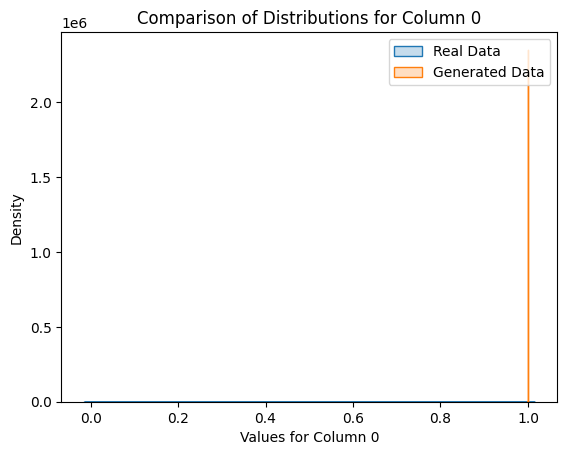

In [ ]:
# Choose the column you want to compare
column_to_compare = 0

# Extract the selected column for each array
real_column = dataNorm[:, column_to_compare]
generated_column = generated_data[:, column_to_compare]

# Plot the KDE for both distributions
sns.kdeplot(real_column, label='Real Data', fill=True)
sns.kdeplot(generated_column, label='Generated Data', fill=True)

# Add labels and legend
plt.title(f'Comparison of Distributions for Column {column_to_compare}')
plt.xlabel(f'Values for Column {column_to_compare}')
plt.ylabel('Density')
plt.legend()
plt.show()


# Valutazione vecchia con dataframe

In [ ]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(dfDDoS)

quality_report = evaluate_quality(
    real_data=dfDDoS,
    synthetic_data=gen_ddos_samples,
    metadata=metadata)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 595/595 [00:11<00:00, 49.64it/s]

Overall Score: 49.21%

Properties:
- Column Shapes: 12.51%
- Column Pair Trends: 85.92%


In [ ]:
diagnostic_report = run_diagnostic(
    real_data=dfDDoS,
    synthetic_data=gen_ddos_samples,
    metadata=metadata)

Generating report ...
(2/2) Evaluating Data Structure: : 100%|██████████| 1/1 [00:00<00:00, 270.41it/s]

Overall Score: 67.22%

Properties:
- Data Validity: 34.44%
- Data Structure: 100.0%


Text(0.5, 1.0, 'synthetic Data')

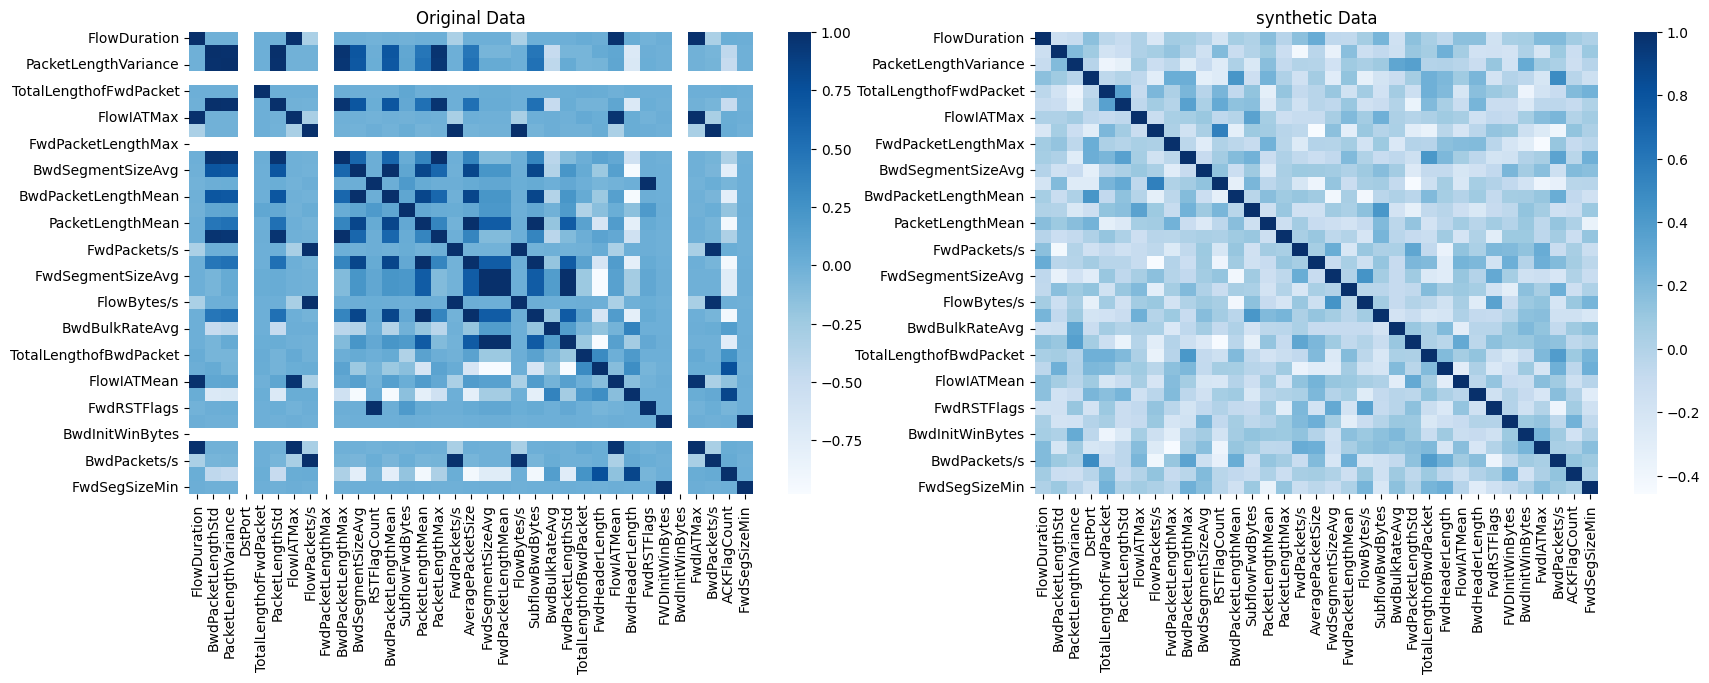

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.heatmap(dfDDoS.corr(), ax=ax[0], cmap="Blues")
sns.heatmap(gen_ddos_samples.corr(), ax=ax[1], cmap="Blues")
ax[0].set_title("Original Data")
ax[1].set_title("synthetic Data")

Text(0.5, 1.0, 'synthetic Data')

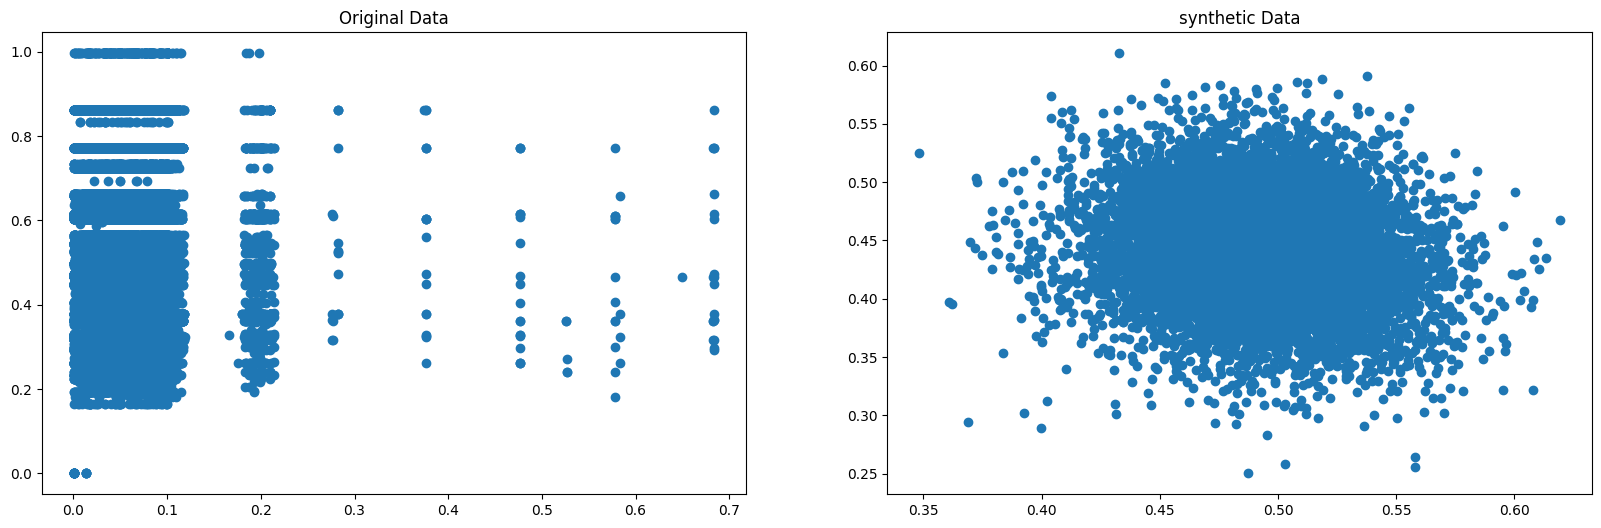

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].scatter(dfDDoS.iloc[:, 0], dfDDoS.iloc[:, 1])
ax[1].scatter(gen_ddos_samples.iloc[:, 0], gen_ddos_samples.iloc[:, 1])
ax[0].set_title("Original Data")
ax[1].set_title("synthetic Data")

KstestResult(statistic=0.9991380488368915, pvalue=0.0, statistic_location=0.2823273820581846, statistic_sign=1)






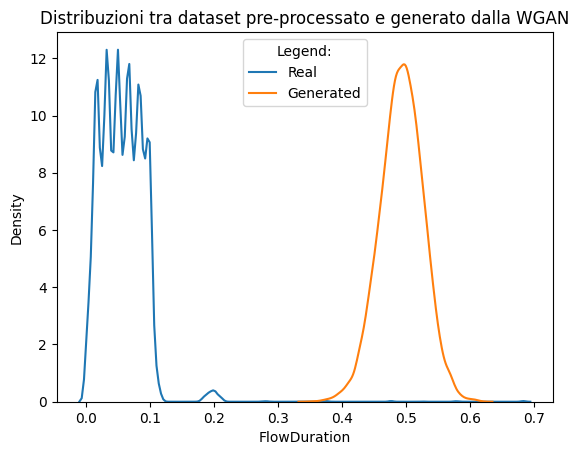

In [ ]:
#Two Sample Kolmogorov-Smirnov Test

from numpy.random import seed

#set seed (e.g. make this example reproducible)
seed(0)

from scipy.stats.mstats import ks_2samp

#perform Kolmogorov-Smirnov test
print(ks_2samp(dfDDoS.FlowDuration, gen_ddos_samples.FlowDuration))
print("\n")
print("=================================================================================================")
print("\n")

#plot distribuzione
sns.kdeplot(dfDDoS['FlowDuration']).set(title='Distribuzioni tra dataset pre-processato e generato dalla WGAN')
sns.kdeplot(gen_ddos_samples['FlowDuration'])
plt.legend(title='Legend:', loc='upper center', labels=['Real', 'Generated'])


KstestResult(statistic=1.0, pvalue=0.0, statistic_location=0.1250019073777371, statistic_sign=1)


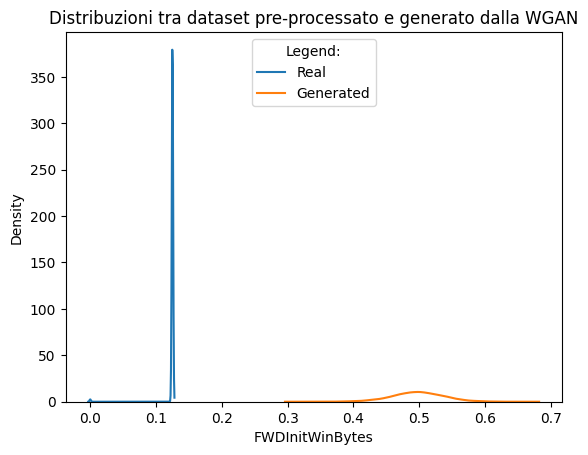

In [ ]:
#perform Kolmogorov-Smirnov test
print(ks_2samp(dfDDoS.FWDInitWinBytes, gen_ddos_samples.FWDInitWinBytes))
print("=================================================================================================")
#plot distribuzione
sns.kdeplot(dfDDoS['FWDInitWinBytes']).set(title='Distribuzioni tra dataset pre-processato e generato dalla WGAN')
sns.kdeplot(gen_ddos_samples['FWDInitWinBytes'])
plt.legend(title='Legend:', loc='upper center', labels=['Real', 'Generated'])